In [1]:
# read the SMILES-MoA data  
import pandas as pd
import numpy as np
df = pd.read_csv('top_20_MOAs.txt', sep = '\t')

In [2]:
# change 20 MoAs to classes 
MOA_class_dictionary = {'EGFR inhibitor': 8,
 'HDAC inhibitor': 16,
 'PI3K inhibitor': 13,
 'acetylcholine receptor agonist': 1,
 'acetylcholine receptor antagonist': 4,
 'adrenergic receptor agonist': 18,
 'adrenergic receptor antagonist': 15,
 'bacterial cell wall synthesis inhibitor': 14,
 'benzodiazepine receptor agonist': 10,
 'calcium channel blocker': 5,
 'cyclooxygenase inhibitor': 6,
 'dopamine receptor antagonist': 12,
 'glucocorticoid receptor agonist': 9,
 'glutamate receptor antagonist': 19,
 'histamine receptor antagonist': 17,
 'phosphodiesterase inhibitor': 3,
 'serotonin receptor agonist': 7,
 'serotonin receptor antagonist': 2,
 'sodium channel blocker': 11,
 'topoisomerase inhibitor': 0}

In [3]:
# add classes column 
df['classes'] = None
for i in range(df.shape[0]):
  df.iloc[i,2] = MOA_class_dictionary[df.iloc[i,1]]

In [4]:
# split out the test set  
from sklearn.model_selection import train_test_split
x_train_valid, x_test, y_train_valid, y_test = train_test_split(df.SMILES, df.classes, test_size =10/100,
 stratify = df.classes, shuffle = True, random_state = 1000)

In [5]:
# kfold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 9)
skf.get_n_splits(np.array(list(x_train_valid)), np.array(list(y_train_valid)))
train_index_list = []
valid_index_list = []
for train_index, valid_index in skf.split(np.array(list(x_train_valid)), np.array(list(y_train_valid))):
  train_index_list.append(train_index)
  valid_index_list.append(valid_index)

In [6]:
number_of_kfold = 0      # change the number from 0-8 to get 9 shuffles
x_train = list(np.array(list(x_train_valid))[train_index_list[ number_of_kfold ]])
x_valid = list(np.array(list(x_train_valid))[valid_index_list[ number_of_kfold ]])
y_train = list(np.array(list(y_train_valid))[train_index_list[ number_of_kfold ]])
y_valid = list(np.array(list(y_train_valid))[valid_index_list[ number_of_kfold ]])
x_test = list(x_test)
y_test = list(y_test)

In [7]:
# turn to cannoical smiles
import rdkit
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
x_train = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in x_train]
x_valid = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in x_valid]
x_test = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in x_test]

In [8]:
# change SMILES to Morgan Fingerprints 
def smiles_to_array(smiles):
  molecules = Chem.MolFromSmiles(smiles) 
  fingerprints = AllChem.GetMorganFingerprintAsBitVect(molecules, 2)
  x_array = []
  arrays = np.zeros(0,)
  DataStructs.ConvertToNumpyArray(fingerprints, arrays)
  x_array.append(arrays)
  x_array = np.asarray(x_array)
  x_array = ((np.squeeze(x_array)).astype(int)) 
  return x_array

In [9]:
# get the training set 
train_x = np.zeros((len(x_train), 2048), dtype = np.float32)
for f in range(train_x.shape[0]):
  train_x[f] = smiles_to_array(x_train[f])

In [10]:
# get the validation set 
valid_x = np.zeros((len(x_valid), 2048), dtype = np.float32)
for f in range(valid_x.shape[0]):
  valid_x[f] = smiles_to_array(x_valid[f])

In [11]:
# get the test set 
test_x = np.zeros((len(x_test), 2048), dtype = np.float32)
for f in range(test_x.shape[0]):
  test_x[f] = smiles_to_array(x_test[f])

In [12]:
y_train = np.array(y_train).astype(int)
y_valid = np.array(y_valid).astype(int)
y_test = np.array(y_test).astype(int)

In [13]:
# create class weights
from sklearn.utils import class_weight
y_unique = np.unique(np.array(y_train))
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = y_unique,
                y = np.array(y_train)) 
class_weights_dict45 = dict(enumerate(class_weights))

In [14]:
# set the architecture of model      
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
num = len(set(df.MOA.tolist()))
input1 = Input(shape=(train_x.shape[1],))
layer = Dense(64, activation='relu')(input1)
layer = Dropout(0.85)(layer)
layer = Dense(num, activation='softmax')(layer)
model1 = Model(inputs = input1, outputs = layer)

In [15]:
# set the checkpoint   
from keras.callbacks import ModelCheckpoint
filepath_mlp = './content/MLP_20_MOA_weights.hdf5'
checkpoint_mlp = ModelCheckpoint(filepath_mlp, monitor='val_accuracy', verbose=0, save_best_only = True,
                mode = 'max')

In [16]:
# compile the model 
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy'])

In [17]:
# train the model 
from tensorflow.keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=25, verbose=0, mode='min')  
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                  factor=0.1, patience=7, verbose=0, min_delta=1e-119, mode='min')
history = model1.fit(train_x, y_train, validation_data=(valid_x, y_valid), class_weight=class_weights_dict45,
            shuffle=True, verbose=2, epochs=1800, batch_size=64,
            callbacks=[earlyStopping, checkpoint_mlp, reduce_lr_loss])

Epoch 1/1800


/usr/local/lib/python3.6/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


16/16 - 2s - loss: 3.0654 - accuracy: 0.0502 - val_loss: 2.9922 - val_accuracy: 0.0738
Epoch 2/1800
16/16 - 0s - loss: 3.0271 - accuracy: 0.0574 - val_loss: 2.9799 - val_accuracy: 0.0902
Epoch 3/1800
16/16 - 0s - loss: 3.0560 - accuracy: 0.0625 - val_loss: 2.9689 - val_accuracy: 0.0902
Epoch 4/1800
16/16 - 0s - loss: 3.0397 - accuracy: 0.0564 - val_loss: 2.9576 - val_accuracy: 0.1148
Epoch 5/1800
16/16 - 0s - loss: 2.9797 - accuracy: 0.0891 - val_loss: 2.9467 - val_accuracy: 0.1148
Epoch 6/1800
16/16 - 0s - loss: 2.9874 - accuracy: 0.0758 - val_loss: 2.9370 - val_accuracy: 0.1311
Epoch 7/1800
16/16 - 0s - loss: 2.9707 - accuracy: 0.0727 - val_loss: 2.9271 - val_accuracy: 0.1475
Epoch 8/1800
16/16 - 0s - loss: 2.9681 - accuracy: 0.0717 - val_loss: 2.9177 - val_accuracy: 0.1885
Epoch 9/1800
16/16 - 0s - loss: 2.9457 - accuracy: 0.0717 - val_loss: 2.9088 - val_accuracy: 0.1967
Epoch 10/1800
16/16 - 0s - loss: 2.9269 - accuracy: 0.0840 - val_loss: 2.8999 - val_accuracy: 0.2131
Epoch 11/180

In [18]:
# Load the best model
from keras.models import load_model
best_model = load_model(filepath_mlp)

In [19]:
# Evaluate the model 
from sklearn.metrics import classification_report
assert list(y_test)[0:5] == [14, 12, 6, 13, 14]
print(classification_report(y_test, np.array(best_model.predict(test_x).argmax(-1)),))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.75      0.75      0.75         4
           2       0.80      0.57      0.67         7
           3       0.57      0.67      0.62         6
           4       0.80      1.00      0.89         8
           5       0.67      0.80      0.73         5
           6       1.00      0.70      0.82        10
           7       0.45      0.83      0.59         6
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         5
          10       1.00      0.50      0.67         4
          11       0.25      0.25      0.25         4
          12       0.67      0.67      0.67         6
          13       0.50      0.25      0.33         4
          14       1.00      0.90      0.95        10
          15       0.80      0.80      0.80        10
          16       1.00      0.75      0.86         4
          17       0.40    

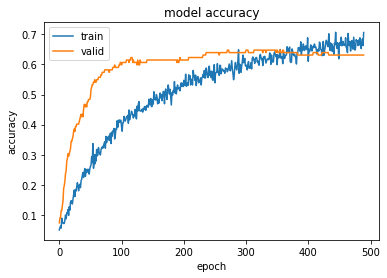

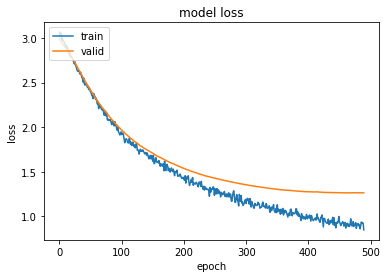

In [20]:
# print out training curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

In [ ]:
# References
# https://future-chem.com/rdkit-google-colab/#toc5
# https://www.rdkit.org/docs/index.html